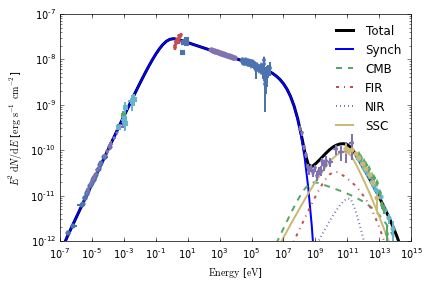

In [5]:
import numpy as np
from astropy.io import ascii
from astropy.constants import c
import astropy.units as u
import naima
from naima.models import (ExponentialCutoffBrokenPowerLaw, Synchrotron,
                          InverseCompton)

%matplotlib inline

ECBPL = ExponentialCutoffBrokenPowerLaw(amplitude=3.699e36 / u.eV,
                                        e_0=1 * u.TeV,
                                        e_break=0.265 * u.TeV,
                                        alpha_1=1.5,
                                        alpha_2=3.233,
                                        e_cutoff=1863 * u.TeV,
                                        beta=2.)

eopts = {'Eemax': 50 * u.PeV, 'Eemin': 0.1 * u.GeV}

SYN = Synchrotron(ECBPL, B=125 * u.uG, Eemax=50 * u.PeV, Eemin=0.1 * u.GeV)

# Compute photon density spectrum from synchrotron emission assuming R=2.1 pc
Rpwn = 2.1 * u.pc
Esy = np.logspace(-7, 9, 100) * u.eV
Lsy = SYN.flux(Esy, distance=0 * u.cm)  # use distance 0 to get luminosity
phn_sy = Lsy / (4 * np.pi * Rpwn**2 * c) * 2.24

IC = InverseCompton(ECBPL,
                    seed_photon_fields=['CMB',
                                        ['FIR', 70 * u.K, 0.5 * u.eV / u.cm**3],
                                        ['NIR', 5000 * u.K, 1 * u.eV / u.cm**3],
                                        ['SSC', Esy, phn_sy]],
                    Eemax=50 * u.PeV, Eemin=0.1 * u.GeV)

# Use plot_data from naima to plot the observed spectra
data = ascii.read('/home/giacomov/software/naima/examples/CrabNebula_spectrum.ecsv')
figure = naima.plot_data(data, e_unit=u.eV)
ax = figure.axes[0]

# Plot the computed model emission
energy = np.logspace(-7, 15, 100) * u.eV

y = IC.sed(energy, 2 * u.kpc) + SYN.sed(energy, 2 * u.kpc)

ax.loglog(energy.value, y.value,
          lw=3, c='k', label='Total')

ax.loglog(energy.value, SYN.sed(energy, 2 * u.kpc).value, lw=2,c='blue',label='Synch')

for i, seed, ls in zip(
        range(4), ['CMB', 'FIR', 'NIR', 'SSC'], ['--', '-.', ':', '-']):
    ax.loglog(energy.value, IC.sed(energy, 2 * u.kpc, seed=seed).value,
              lw=2, c=naima.plot.color_cycle[i + 1], label=seed, ls=ls)


ax.set_ylim(1e-12, 1e-7)
ax.legend(loc='upper right', frameon=False)
figure.tight_layout()